In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/day.csv')

In [3]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Data Quality Checks

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


No missing values

**Visualizing Continuous Variables**

In [5]:
# dropping `instant`,`dteday`,`casual`,`registered`

data = data.drop(columns=['instant','dteday','casual','registered'])

These variables were dropped since instant is the just the serial number of the record, dteday is redundant coz the required data for analysis is contained in mnth,yr casual + registered = cnt

In [6]:
# summary statistics of numerical variables
data[['temp','atemp','hum','windspeed']].describe()

,temp,atemp,hum,windspeed
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620
std,7.506729,8.150308,14.237589,5.195841
min,2.424346,3.953480,0.000000,1.500244
25%,13.811885,16.889713,52.000000,9.041650
50%,20.465826,24.368225,62.625000,12.125325
75%,26.880615,30.445775,72.989575,15.625589
max,35.328347,42.044800,97.250000,34.000021


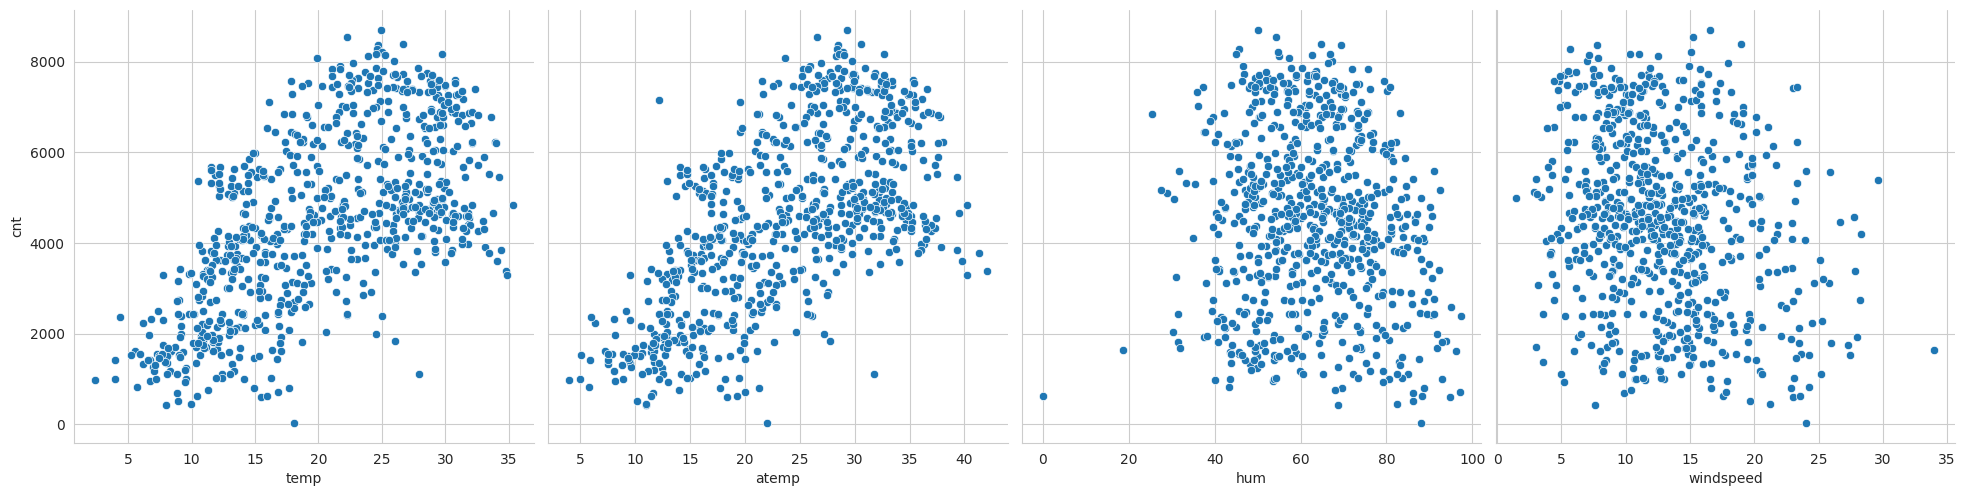

In [7]:
# Scatter Plots of Continuous variables vs 'cnt'
sns.set_style("whitegrid")
sns.pairplot(data=data,x_vars=['temp','atemp','hum','windspeed'],y_vars='cnt',kind='scatter',height=5,aspect=1);

The number of rentals per day seem to be increasing with temperature and adjusted temperature
adjusted temperature and temperature have similar trends
temp vs cnt has two outliers between 15 and 30
atemp vs cnt has two outliers between 20 and 35
hum vs cnt has two outliers below 20
windspeed vs cnt has one outlier above 30

**Outliers in Continuous Variables vs cnt**

In [8]:
## Dropping outliers in continuous variables
# outliers in temp
data = data.drop(index = data[(data['temp'] > 15) & (data['temp'] < 20) & (data['cnt'] < 100)].index)
data = data.drop(index = data[(data['temp'] > 25) & (data['temp'] < 30) & (data['cnt'] < 2000)].index)


# outliers in atemp
data = data.drop(index = data[(data['atemp'] > 20) & (data['atemp'] < 25) & (data['cnt'] < 100)].index)
data = data.drop(index = data[(data['atemp'] > 30) & (data['atemp'] < 35) & (data['cnt'] < 2000)].index)


#outliers in hum
data = data.drop(index = data[(data['hum'] < 20)].index)

#outliers in windspeed
data = data.drop(index = data[(data['windspeed'] > 30)].index)

In [9]:
# Looking at correlation with continuous variables
correlation = data[['temp','atemp','hum','windspeed','cnt']].corr()['cnt'].apply(lambda x : round(x,4))
correlation = pd.DataFrame(correlation).sort_values(by='cnt',ascending=False)
correlation.drop(index=['cnt'],inplace=True)
# dropping registered,casual, instant
correlation.style.background_gradient(cmap='GnBu')

,cnt
atemp,0.638900
temp,0.635600
hum,-0.107600
windspeed,-0.218100


1.adjusted temperature has the highest positive correlation with cnt followed by temperature.
2.hum has the lowest correlation.

In [10]:
# correlation between ```temp``` and ```atemp```
data[['temp','atemp']].corr()

,temp,atemp
temp,1.000000,0.991726
atemp,0.991726,1.000000


Since, the correlation between temp and atemp is almost 1, one of them could be dropped.
atemp represents adjusted temperature which is an indicator of how hot it actually feels like which is a compound measure of temperature,humidity and windspeed. Ref : UK Meteorological Dept
atemp might cause bias in data because it's a compound variable, Instead we could use temp , hum , windspeed. Hence , dropping atemp. Also it makes business sense to keep temp and calcuate adjusted temperature from it.

In [11]:
# dropping ```atemp```
data = data.drop(columns=['atemp'])

In [12]:
data[['temp','hum','windspeed']].corr()

,temp,hum,windspeed
temp,1.000000,0.122673,-0.160295
hum,0.122673,1.000000,-0.247498
windspeed,-0.160295,-0.247498,1.000000


There's no signifcant correlation between atemp and hum , windspeed.
Hence these are not dropped for now.

**Visualizing Categorical Variables**

In [13]:
# Converting variables into categorical type
data[['season','weathersit','mnth']] = data[['season','weathersit','mnth']].astype('category')

In [14]:
# Unique values in each categorical variable / [To check for disguised missing values]
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
for i in cat_vars :
    print('Unique values in ',i, data[i].unique())

Unique values in  season [1, 2, 3, 4]
Categories (4, int64): [1, 2, 3, 4]
Unique values in  yr [0 1]
Unique values in  mnth [1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]
Unique values in  holiday [0 1]
Unique values in  weekday [6 0 1 2 3 4 5]
Unique values in  workingday [0 1]
Unique values in  weathersit [2, 1, 3]
Categories (3, int64): [1, 2, 3]


No disguised missing values exist

In [15]:
# Replacing numbers with labels
season_labels = {
    1 : 'spring',
    2 : 'summer',
    3 : 'fall',
    4 : 'winter'
}

mnth_labels = {
    1 : 'january',
    2 : 'february',
    3 : 'march',
    4 : 'april',
    5 : 'may',
    6 : 'june',
    7 : 'july',
    8 : 'august',
    9 : 'september',
    10 : 'october',
    11 : 'november',
    12 : 'december'
}

weekday_labels = { # considering the first row of dteday to be 01-01-2011
    0 : 'Sunday',
    1 : 'Monday',
    2 : 'Tuesday',
    3 : 'Wednesday',
    4 : 'Thursday',
    5 : 'Friday',
    6 : 'Saturday'
}

weathersit_labels = {
    1 : 'clear',
    2 : 'cloudy',
    3 : 'light snow/rain'
}

# replacing numerals with labels
data['season'] = data['season'].replace(season_labels)
data['mnth'] = data['mnth'].replace(mnth_labels)
data['weekday'] = data['weekday'].replace(weekday_labels)
data['weathersit'] = data['weathersit'].replace(weathersit_labels)

data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,january,0,Saturday,0,cloudy,14.110847,80.5833,10.749882,985
1,spring,0,january,0,Sunday,0,cloudy,14.902598,69.6087,16.652113,801
2,spring,0,january,0,Monday,1,clear,8.050924,43.7273,16.636703,1349
3,spring,0,january,0,Tuesday,1,clear,8.200000,59.0435,10.739832,1562
4,spring,0,january,0,Wednesday,1,clear,9.305237,43.6957,12.522300,1600


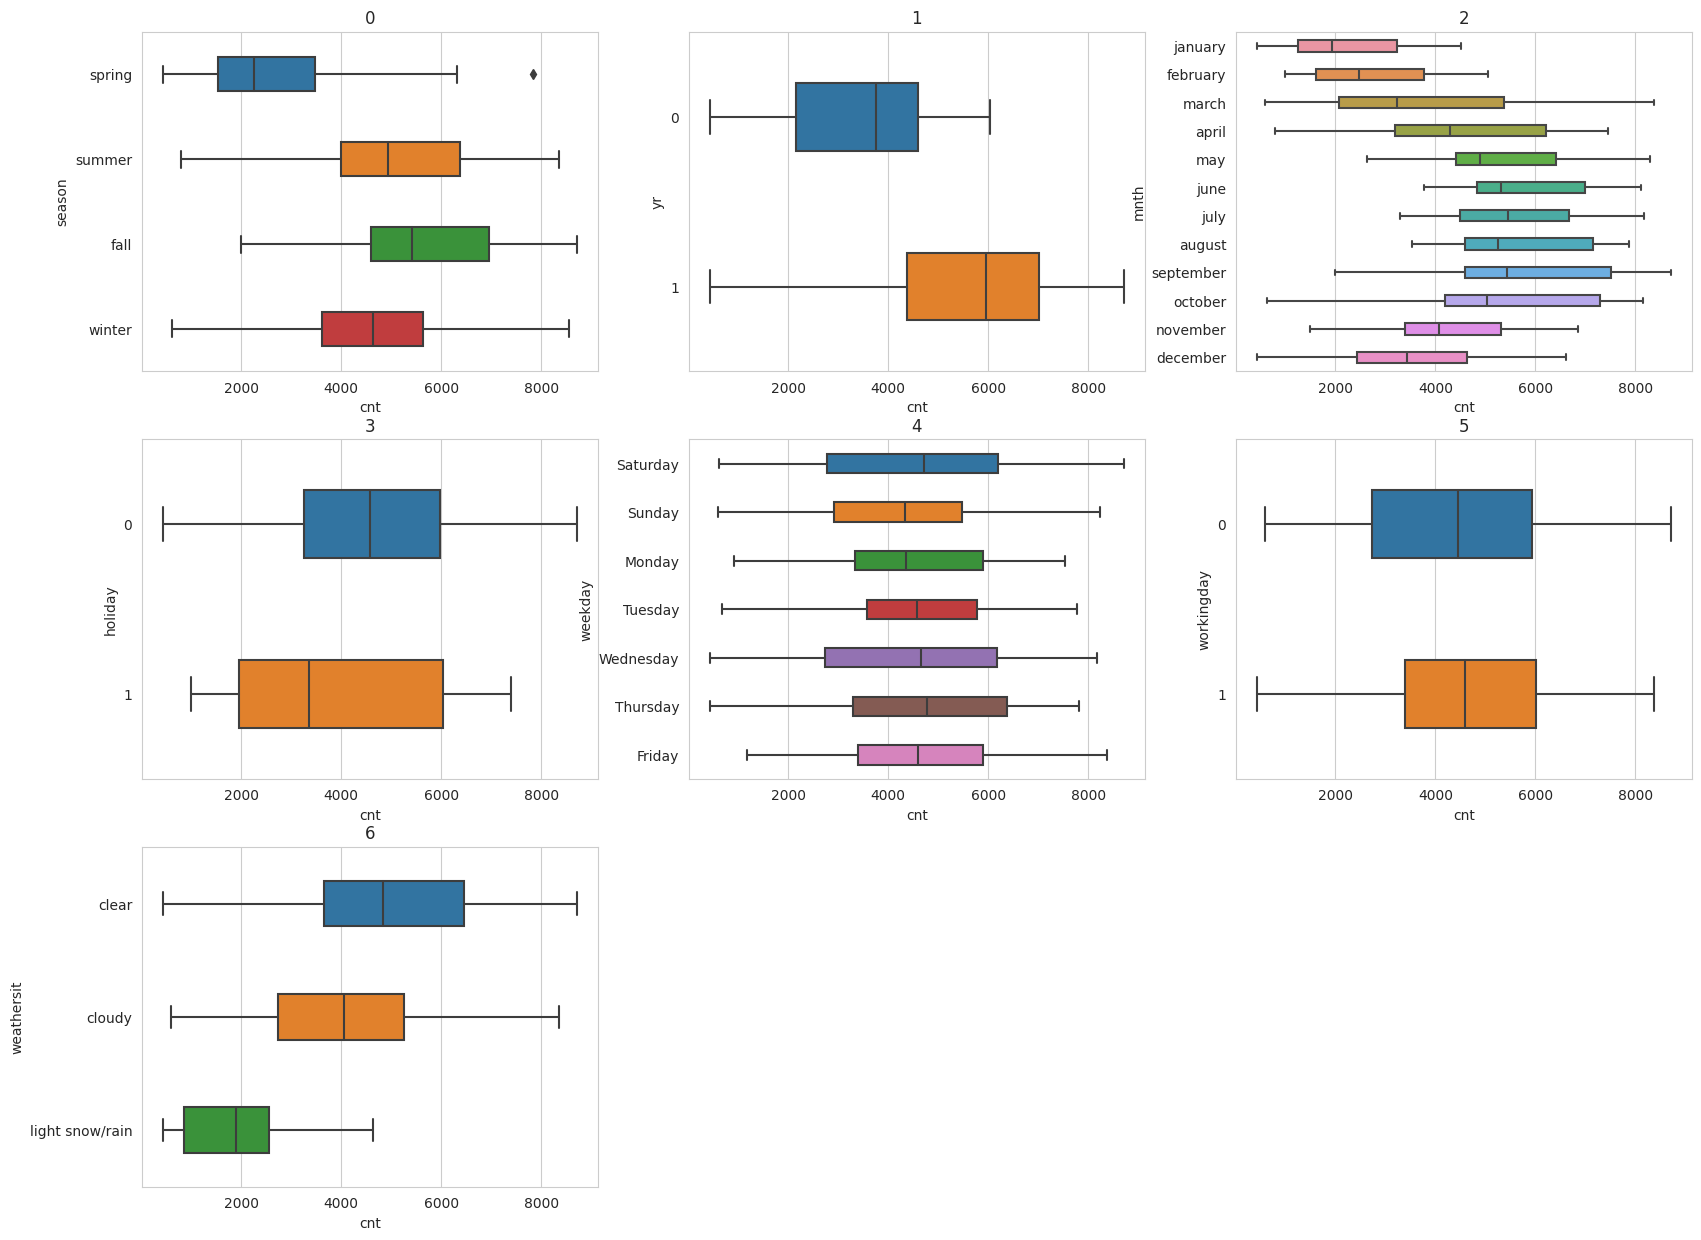

In [16]:
cat_vars = ['season','yr','mnth','holiday','weekday',  'workingday','weathersit']
data1 = data[cat_vars]
data1.loc[:,'cnt'] = data['cnt'].values
data1[['yr','holiday','workingday']] = data1[['yr','holiday','workingday']].astype('category')
plot_dim = [3,3]
fig,axs = plt.subplots(*plot_dim)
fig.set_figheight(15)
fig.set_figwidth(20)
for i in range(plot_dim[0]) :
    for j in range(plot_dim[1]) :
        axs[i,j].set(title = i*plot_dim[1]+j)
        sns.boxplot(data=data1,x='cnt',y=cat_vars[i*plot_dim[1]+j],width=0.4,ax=axs[i,j])
        if i*plot_dim[1]+j == 6 :
            break
axs[2,1].set_axis_off()
axs[2,2].set_axis_off()

*From the season vs rentals per day plot , fall has the highest average rentals followed by summer.
*Looking at year by year rentals, 2019 has had a median 2000 increase in rentals compared to 2018.
*From the month wise plot, September has the highest rentals, followed by the two months surrounding it. It seems like the trend is explained by seasonal rentals too
*Holidays show lower rental count compared to working days, with greater variability in demand on holidays.
*There is no significant difference between rentals vs weekdays, except that Thursdays and sundays have a higher variation in rentals than others.

**Outliers in Categorical Variables vs cnt**

In [17]:
# Dropping outliers in Categorical Variables
data = data.drop(index = data[(data['season'] == 'spring') & (data['cnt'] > 7000)].index)

**Correlation**

<Axes: >

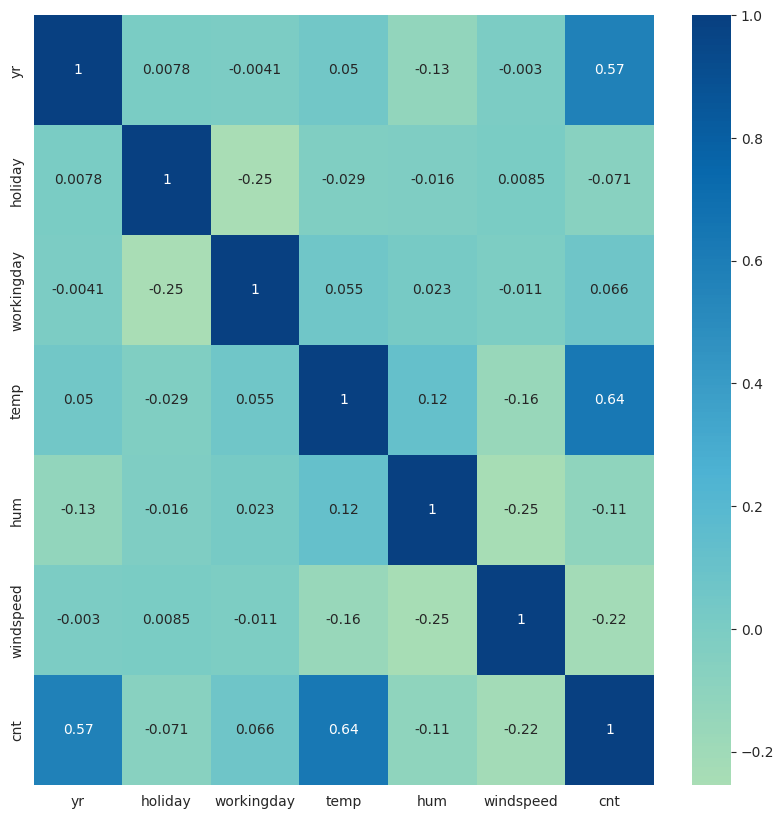

In [18]:
# correlation among variables
plt.figure(figsize=[10,10])
sns.heatmap(data.corr(),cmap='GnBu',center=0,annot=True)

Highest correlation with cnt is seen in temp followed by yr

**Data Preparation**

**Creating Indictor Variables**

In [19]:
# creating indicator variable columns
season_indicators = pd.get_dummies(data['season'],drop_first=True)
mnth_indicators = pd.get_dummies(data['mnth'],drop_first=True)
weekday_indicators = pd.get_dummies(data['weekday'],drop_first=True)
weathersit_indicators = pd.get_dummies(data['weathersit'],drop_first=True)

In [20]:
# adding indicator variable columns to the dataset . Dropping original columns
data = pd.concat([data,season_indicators,mnth_indicators,weekday_indicators,weathersit_indicators],axis=1)
data = data.drop(columns=['season','mnth','weekday','weathersit'])

In [21]:
data.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,november,december,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,cloudy,light snow/rain
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
data.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'summer', 'fall', 'winter', 'february', 'march', 'april', 'may', 'june',
       'july', 'august', 'september', 'october', 'november', 'december',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'cloudy', 'light snow/rain'],
      dtype='object')

**Splitting the data set into Test & Train subsets**

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
dtrain,dtest = train_test_split(data,train_size=0.7,test_size=0.3,random_state=120)

**Scaling Numerical Features**

In [25]:
# normalization of continuous variables
from sklearn.preprocessing import MinMaxScaler
numerical_scaler = MinMaxScaler()
num_vars = ['temp','hum','windspeed']

numerical_scaler.fit(dtrain[num_vars])
dtrain[num_vars] = numerical_scaler.transform(dtrain[num_vars])

**X_train , y_train**

In [26]:
y_train = dtrain.pop('cnt')
X_train = dtrain

In [27]:
y_train.head()

231    5191
717    5267
107    3429
595    4549
485    5740
Name: cnt, dtype: int64

In [28]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,summer,fall,winter,february,...,november,december,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,cloudy,light snow/rain
231,0,0,0,0.795440,0.584687,0.155696,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
717,1,0,1,0.340632,0.516822,0.355128,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
107,0,0,1,0.564921,0.401392,0.303720,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
595,1,0,0,0.718600,0.636891,0.110569,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
485,1,0,1,0.690564,0.564384,0.285008,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [29]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'fall', 'winter', 'february', 'march', 'april', 'may', 'june', 'july',
       'august', 'september', 'october', 'november', 'december', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'cloudy',
       'light snow/rain'],
      dtype='object')

**Modelling**

Approach

A mixed approach is followed.
15 Best columns are chosen using RFE
And then p-value method is followed for further elimination.



**Recursive Feature Elimination**

In [30]:
# Selecting 15 Features using RFE

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr_estimator = LinearRegression()
rfe = RFE(lr_estimator,n_features_to_select=15, step=1)
selector = rfe.fit(X_train,y_train)

In [31]:
# RFE Feature Ranking
rfe_ranking = pd.DataFrame({'rank' : selector.ranking_, 'support': selector.support_, 'features' : X_train.columns}).sort_values(by='rank',ascending=True)
rfe_ranking

,rank,support,features
0,1,True,yr
22,1,True,Sunday
21,1,True,Saturday
15,1,True,august
14,1,True,july
8,1,True,winter
7,1,True,fall
13,1,True,june
5,1,True,windspeed
1,1,True,holiday


In [32]:
# Selected Features
selected_features = rfe_ranking.loc[rfe_ranking['rank'] == 1,'features'].values
selected_features

array(['yr', 'Sunday', 'Saturday', 'august', 'july', 'winter', 'fall',
       'june', 'windspeed', 'holiday', 'workingday', 'summer', 'temp',
       'hum', 'light snow/rain'], dtype=object)

**Manual Elimination**

In [33]:
# Following a stepwise elimination
import statsmodels.api as sm
def ols_fit(y,X) :
    X_train_sm = sm.add_constant(X)
    model = sm.OLS(y,X_train_sm).fit()
    print(model.summary())
    return model
def vif(X) :
    df = sm.add_constant(X)
    vif = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif_frame = pd.DataFrame({'vif' : vif[0:]},index = df.columns).reset_index()
    print(vif_frame.sort_values(by='vif',ascending=False))

Model 1
Using features selected by RFE : 'yr', 'Sunday', 'Saturday', 'november', 'january', 'december',
 'winter', 'july', 'spring', 'holiday', 'workingday', 'hum', 'temp',
 'windspeed', 'light snow/rain'

In [34]:
features_1 = selected_features
ols_fit(y_train,X_train[features_1])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     190.2
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          5.83e-188
Time:                        10:16:56   Log-Likelihood:                -4071.9
No. Observations:                 506   AIC:                             8174.
Df Residuals:                     491   BIC:                             8237.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1116.9788    142.469     

**Model 2 :**

Dropping holiday because of high p-value

In [35]:
del_feature = 'holiday'
selected_features = selected_features[selected_features!=del_feature]
ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     190.2
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          5.83e-188
Time:                        10:18:05   Log-Likelihood:                -4071.9
No. Observations:                 506   AIC:                             8174.
Df Residuals:                     491   BIC:                             8237.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             913.1879    252.029     

**Model 3 :**

Dropping Sunday because of high p-value

In [36]:
del_feature = 'Sunday'
selected_features = selected_features[selected_features!=del_feature]
ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          4.16e-188
Time:                        10:19:15   Log-Likelihood:                -4074.3
No. Observations:                 506   AIC:                             8177.
Df Residuals:                     492   BIC:                             8236.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1277.3108    188.988     

**Model 4**

Dropping january because this information might also be contained in winter.

In [37]:
del_feature = 'january'
selected_features = selected_features[selected_features!=del_feature]
ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          4.16e-188
Time:                        10:20:06   Log-Likelihood:                -4074.3
No. Observations:                 506   AIC:                             8177.
Df Residuals:                     492   BIC:                             8236.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1277.3108    188.988     

**Model 5**

Dropping december because this information might also be contained in winter.

In [38]:
del_feature = 'december'
selected_features = selected_features[selected_features!=del_feature]
ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          4.16e-188
Time:                        10:22:15   Log-Likelihood:                -4074.3
No. Observations:                 506   AIC:                             8177.
Df Residuals:                     492   BIC:                             8236.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1277.3108    188.988     

**Model 6**

Dropping november because this information might also be contained in winter.

In [39]:
del_feature = 'november'
selected_features = selected_features[selected_features!=del_feature]
final_model = ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          4.16e-188
Time:                        10:25:21   Log-Likelihood:                -4074.3
No. Observations:                 506   AIC:                             8177.
Df Residuals:                     492   BIC:                             8236.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1277.3108    188.988     

**Verifying MultiCollinearity**

In [40]:
vif(X_train[selected_features])

              index        vif
0             const  30.439442
6              fall   5.635145
11             temp   4.262792
10           summer   2.689653
4              july   2.218186
3            august   2.067460
5            winter   1.857751
2          Saturday   1.611728
9        workingday   1.606158
7              june   1.461180
12              hum   1.357820
13  light snow/rain   1.186426
8         windspeed   1.169978
1                yr   1.036311


**Final Model**

In [41]:
final_model = ols_fit(y_train,X_train[selected_features])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          4.16e-188
Time:                        10:28:56   Log-Likelihood:                -4074.3
No. Observations:                 506   AIC:                             8177.
Df Residuals:                     492   BIC:                             8236.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1277.3108    188.988     

*10 features have been selected.
*All the features are statistically significant [low p-value]
*The model over is a good fit with Prob (F-statistic): 4.89e-187
*The model explains 83.6% variability in the training data. Adjusted *R-square being 83.3%

**Residual Analysis**

TypeError: ignored

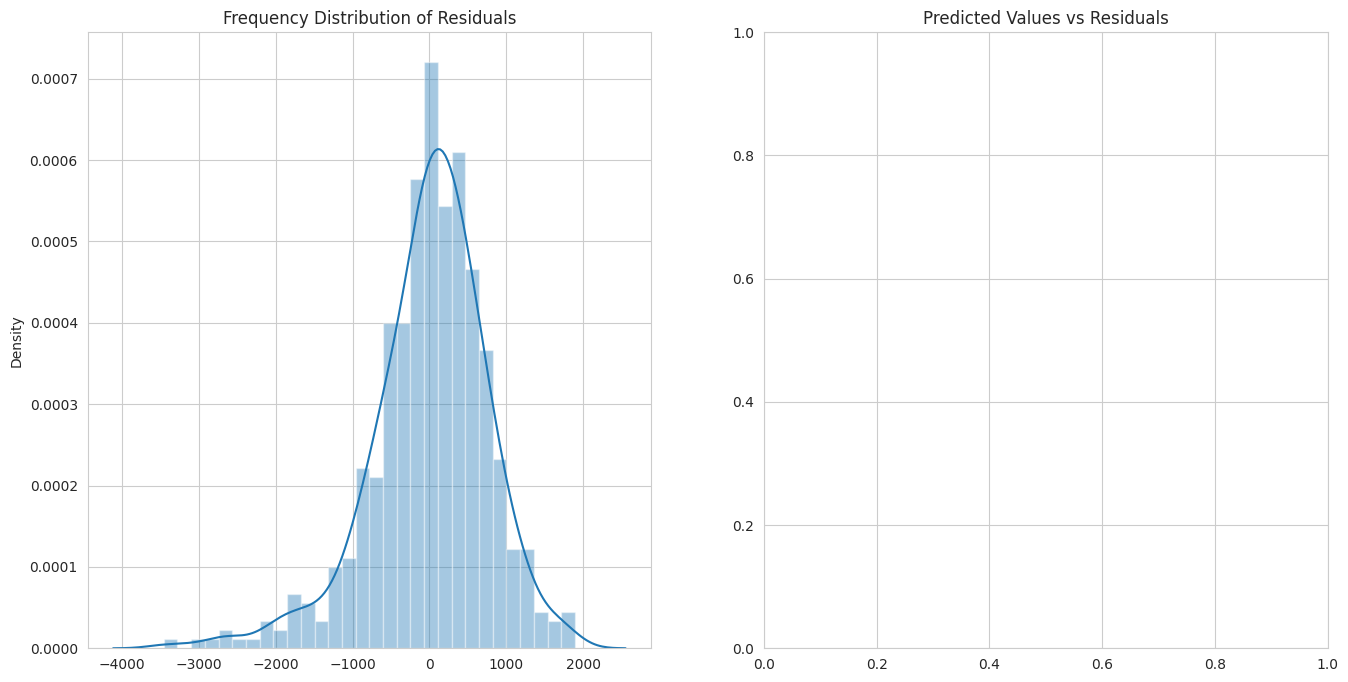

In [56]:
# Residual Analysis of Trained Data
X_train_sm = sm.add_constant(X_train[selected_features])

y_train_pred = final_model.predict(X_train_sm)
fig,ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

ax[0].set(title='Frequency Distribution of Residuals')
sns.distplot(y_train-y_train_pred, bins=30, ax=ax[0])

ax[1].set(title='Predicted Values vs Residuals')
\
sns.regplot(y_train_pred,y_train-y_train_pred,ax=ax[1])
plt.show()

In [43]:
# Mean of Residuals
(y_train-y_train_pred).mean()

-2.9693384334562794e-12

Residual errors follow a normal distribution with mean=0
Variance of Errors doesnt follow any trends
Residual errors are independent of each other since the Predicted values vs Residuals plot doesn't show any trend.

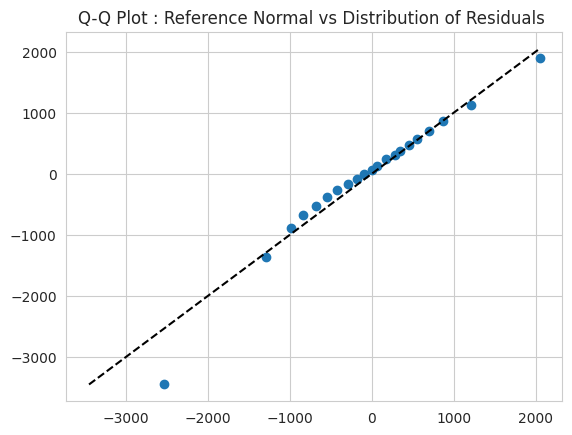

In [44]:
# Verifying the normality of distribution of residuals
mean = (y_train-y_train_pred).mean()
std = (y_train-y_train_pred).std()

ref_normal = np.random.normal(mean,std,(y_train-y_train_pred).shape[0])


percs = np.linspace(0,100,21)
qn_ref_normal = np.percentile(ref_normal, percs)
qn_residual = np.percentile(y_train - y_train_pred , percs)

plt.plot(qn_ref_normal,qn_residual, ls="", marker="o")

x = np.linspace(np.min((qn_ref_normal.min(),qn_residual.min())), np.max((qn_ref_normal.max(),qn_residual.max())))
plt.plot(x,x, color="k", ls="--")
plt.title('Q-Q Plot : Reference Normal vs Distribution of Residuals ')
plt.show()

This plot further shows that the residual distribution is approximately normal for all test data with values within range of training data. Extrapolated points show significant predict inaccuracy.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

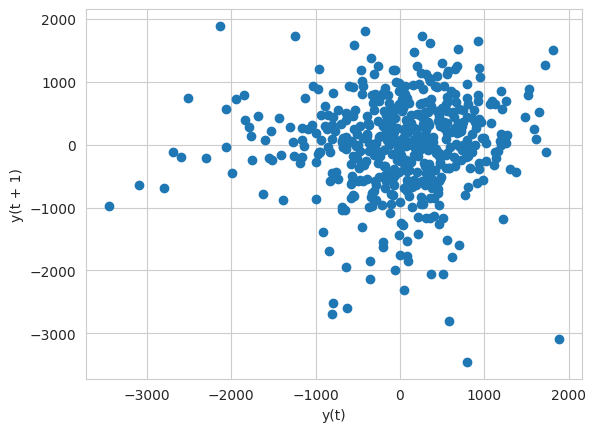

In [45]:
# lag plot to assess independence of data points
from pandas.plotting import lag_plot
lag_plot(y_train-y_train_pred)

Lagplot of residuals shows no trend. Hence the error terms have constant variance

**Hence, assumptions of Linear Regression are satisfied by this model**

**Prediction**

In [46]:
y_test = dtest.pop('cnt')
X_test = dtest
X_test[num_vars] = numerical_scaler.transform(X_test[num_vars])
X_test = X_test[selected_features]

In [47]:
X_test = sm.add_constant(X_test)
y_test_pred = final_model.predict(X_test)

**Model Evaluation**

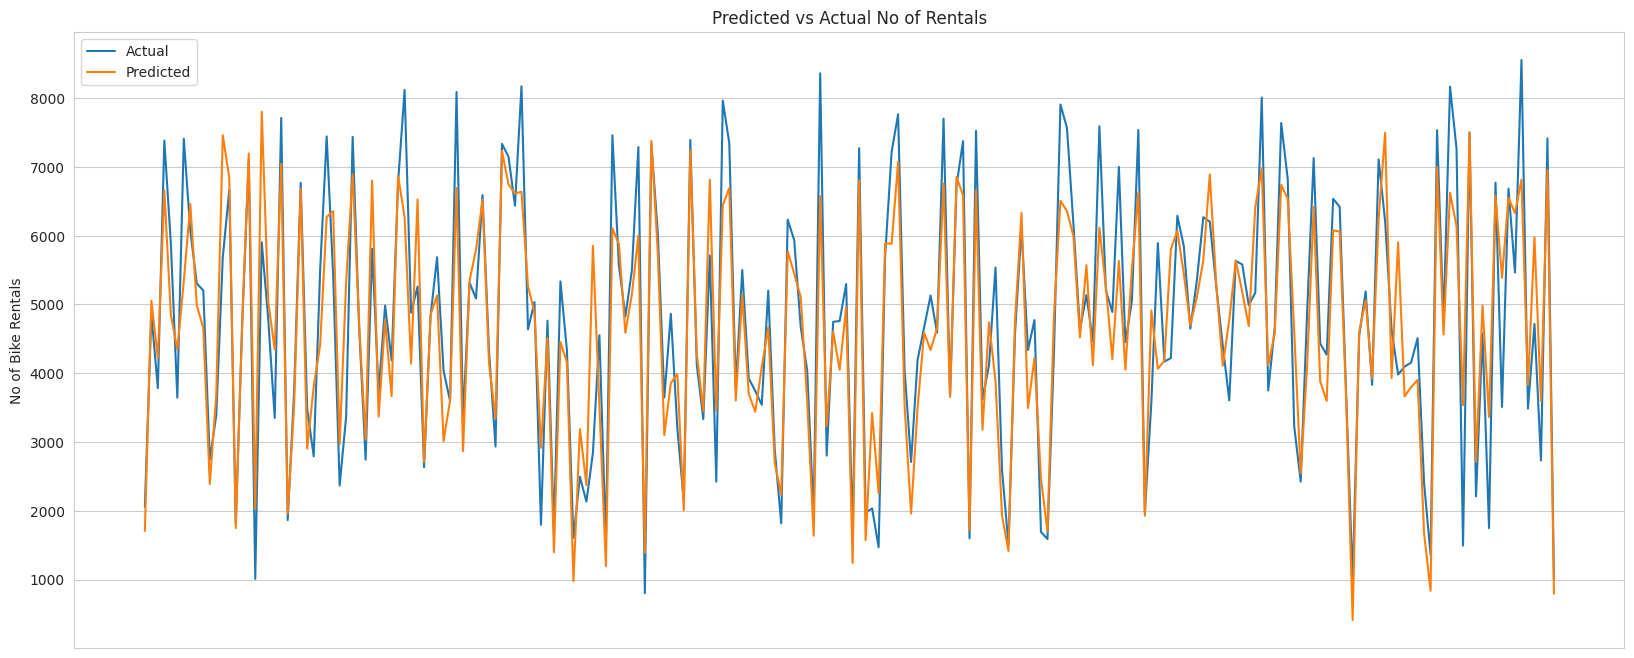

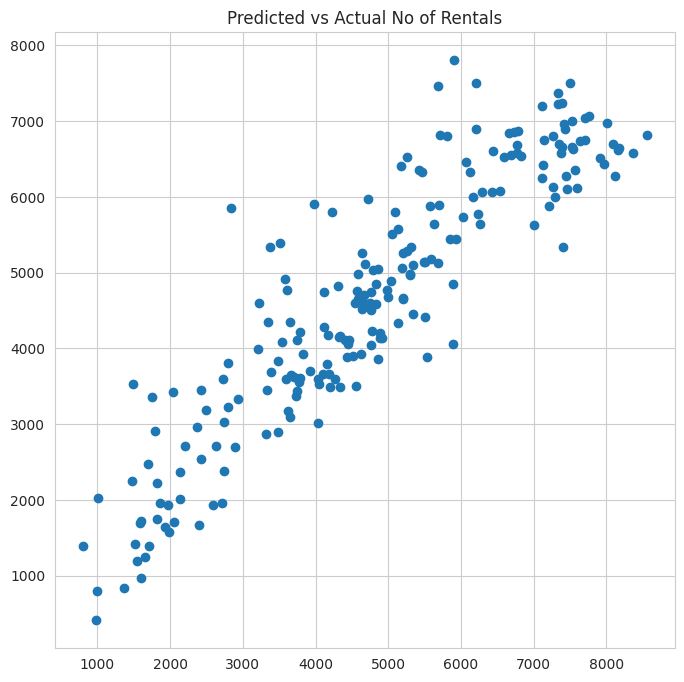

In [48]:
# Plotting Actual vs Predicted No of rentals
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_test)),y_test)
l2, = ax.plot(range(len(y_test_pred)),y_test_pred)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs Actual No of Rentals');
plt.ylabel('No of Bike Rentals')
plt.xticks([])
plt.show()

plt.figure(figsize=[8,8])
plt.scatter(y_test,y_test_pred);
plt.title('Predicted vs Actual No of Rentals');

Predicted vs observed value plots shows that the model is reasonably accurate.

In [49]:
from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(y_test, y_test_pred)
rsquared_test = r2_score(y_test, y_test_pred)
rsquared_train = r2_score(y_train, y_train_pred)
print('R-squared for train data:',round(rsquared_train,2))
print('R-squared for test data:',round(rsquared_test,2))
print('Mean Squared Error',round(mse,3))

R-squared for train data: 0.84
R-squared for test data: 0.82
Mean Squared Error 660032.6


**Model Stability**

In [50]:
# R-square using cross validation

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
clr = cross_val_score(lr,X_train[selected_features],y_train,cv=10, scoring='r2')
clr

array([0.78945099, 0.89198592, 0.74449644, 0.88238484, 0.84330374,
       0.85011621, 0.87880853, 0.71562285, 0.73858615, 0.87479928])

In [51]:
print("R-square at 0.95 confidence level : %0.2f (+/- %0.2f)" % (clr.mean(), clr.std() * 2))

R-square at 0.95 confidence level : 0.82 (+/- 0.13)


In [52]:
selected_features

array(['yr', 'Saturday', 'august', 'july', 'winter', 'fall', 'june',
       'windspeed', 'workingday', 'summer', 'temp', 'hum',
       'light snow/rain'], dtype=object)

**Top Features**

In [53]:
# standardizing numerical variables

from sklearn.preprocessing import StandardScaler
reg_features = selected_features
scaler = StandardScaler()
data = X_train[selected_features]
std_num = scaler.fit(data[['temp','windspeed','hum']])


std_X_train = pd.DataFrame(data = scaler.transform(data[['temp','windspeed','hum']]), columns=['temp','windspeed','hum'])
for i in reg_features :
    std_X_train[i] = data[i].values


reshaped_y_train = y_train.values.reshape(-1,1)

# Fitting linear regression model
std_model = lr.fit(std_X_train, reshaped_y_train)

# Coefficients and intercept
result = pd.DataFrame(data = std_model.coef_, columns = std_X_train.columns, index=['MLR Coefficients']).T
result = result.sort_values(by='MLR Coefficients',ascending=False)
print('\nIntercept :',std_model.intercept_)
result


Intercept : [1277.3108355]


,MLR Coefficients
temp,5059.413833
yr,1935.848743
winter,1447.471094
fall,1151.267012
summer,1042.865213
Saturday,439.518753
workingday,308.729624
june,-500.735067
august,-695.612274
windspeed,-1188.078390


Upon standardized the values of predictor variables, the above shows that the top features influencing demand are temp, followed by yr and hum
In case of continuous variables, the above data could be interpreted as - With every standard deviation increase in continuous variables, demand increases by xxx, when all other modelled paramters are held unchanged.
In case of categorical variables, the above data could be interpreted as - Compared to the reference level, the change in demand is xxx,, when all other modelled paramters are held unchanged.

**Conclusion**

Analysis is carried out using a Mixed Feature Selection Approach. 15 features are selected algorithmically using Recursive Feature Elimination. Further selection is done manually by looking at multicollinearity and statistical significance of features and overall fit of the model. The 10 most significant features to understand demand have been reported.

The data set is randomly divided into training and test data. Final Model built on training data set explains 84% of the variability and achieves 81% on test data.

The final relationship between demand and predictors is as follows.

cnt = 2392.0791 + 1946.7864 yr + 444.4907 Saturday + 466.0136 winter - 890.3115 july -1063.6669 spring + 296.8008 workingday - 1749.8275 hum + 4471.6602 temp - 1110.3191 windspeed - 1273.7519 light snow/rain
where temp , windspeed and hum are normalized.

Note :

Data has been cleaned to drop outliers that might affect the model adversely
The model has been verified for Multicollinearity effects.
Residual Analysis has been carried out and the model satisfies the assumptions of Linear Regression (Residuals follow a normal distribution, Errors exhibit homoscedasticity)
Q-Q plot between residual distribution and normal distribution shows that residuals follow a normal distribution for all interpolations. Extraplorations show significant deviation, not affecting Linear Regression applicability.
Further Lag plot shows there is no auto-correlation in data.
Model is stable at 81%(+/-14%) coefficient of determination at 95% CI, ascertained through cross validation.
Features in the order of influence has been reported by standardizing all predictor values.